# Train neural network

## Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import requests
import datetime
import pickle

import eeweather
import pytz

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

2.2.0


## Hyperparameter

In [7]:
PATH_DF_01 = '/home/ubuntu/github/airflow-automation/02_df/df_model_data.pkl'
PATH_DF_02 = '/home/ubuntu/github/airflow-automation/02_df/df_train.pkl'
PATH_DF_03 = '/home/ubuntu/github/airflow-automation/02_df/df_vali.pkl'
PATH_DF_04 = '/home/ubuntu/github/airflow-automation/02_df/df_test.pkl'
PATH_MODEL = '/home/ubuntu/github/airflow-automation/03_model/nn.h5'
PATH_SCALER = '/home/ubuntu/github/airflow-automation/03_model/scaler.pkl'

URL_EIA_01 = 'http://api.eia.gov/series/?api_key='
URL_EIA_02 = '&series_id='
API_KEY = '1f251657d4404b4115a5d852206cceb1'
SERIES_ID = 'EBA.PSCO-ALL.D.H'
NAME = 'load'

# denver international airport
LAT = 39.8328
LON = -104.6575

SPLIT_01 = '20190630'
SPLIT_02 = '20190701'

TEST_SIZE = 0.3
RANDOM_STATE = 123

DELTA = 0.01
LEARNING_RATE = 1e-4
PATIENCE = 10
BATCH_SIZE = 128
EPOCHS = 1500

## Function

In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    return float(np.mean(np.abs((y_true - y_pred) / y_true)))

## Model data

In [9]:
df_model = pickle.load(open(PATH_DF_01, 'rb'))

In [10]:
df_model.head(2)

,load,temp_f,year,month,day,hour,dow
period,,,,,,,
2015-07-01 01:00:00,4875.0,68.77544,2015,7,1,1,2
2015-07-01 02:00:00,4618.0,66.80714,2015,7,1,2,2


In [11]:
df_model.tail(2)

,load,temp_f,year,month,day,hour,dow
period,,,,,,,
2020-08-02 08:00:00,4642.0,NaN,2020,8,2,8,6
2020-08-02 09:00:00,4918.0,NaN,2020,8,2,9,6


## Train test split

In [12]:
df_train = df_model[:SPLIT_01]
df_test = df_model[SPLIT_02:]
print('train', df_train.index[0], df_train.index[-1])
print('test', df_test.index[0], df_test.index[-1])

train 2015-07-01 01:00:00 2019-06-30 23:00:00
test 2019-07-01 00:00:00 2020-08-02 09:00:00


## Clean data 

In [13]:
df_train = df_train.loc[df_train['load'] < 10000]
df_train = df_train.loc[df_train['load'] > 2000]
# 2017-03-16 11:00:00	8583.0
df_train = df_train.loc[df_train.index != datetime.datetime(2017, 3, 16, 11)]
df_train = df_train.dropna()

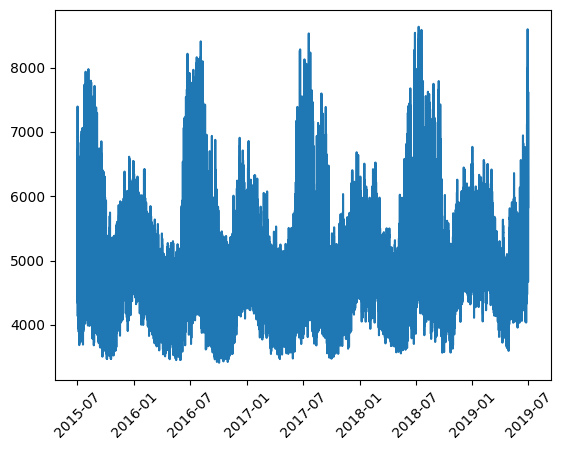

In [14]:
plt.plot(df_train['load'])
plt.xticks(rotation = 45)
plt.show()

## Train validation split

In [15]:
y = df_train[['load']]
X = df_train[['temp_f', 'year', 'month', 'day', 'hour', 'dow']]
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE)

## Normalize data

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_vali_scaled = scaler.transform(X_vali)
print('train, min:{:.1f}, mean:{:.1f}, max:{:.1f}'.format(np.min(X_train_scaled), np.mean(X_train_scaled), np.max(X_train_scaled)))
print('validation, min:{:.1f}, mean:{:.1f}, max:{:.1f}'.format(np.min(X_vali_scaled), np.mean(X_vali_scaled), np.max(X_vali_scaled)))

train, min:-3.2, mean:0.0, max:2.5
validation, min:-3.0, mean:0.0, max:2.5


## Model

In [17]:
def instantiate_model(train):
    model = Sequential(name = 'load_forecast_neural_network')
    model.add(Dense(48, activation = 'relu', name = 'hidden_dense_1',
                    input_shape = (train.shape[1],)))
    model.add(Dense(48, activation = 'relu', name = 'hidden_dense_2'))
    model.add(Dense(48, activation = 'relu', name = 'hidden_dense_3'))
    model.add(Dense(48, activation = 'relu', name = 'hidden_dense_4'))
    model.add(Dense(48, activation = 'relu', name = 'hidden_dense_5'))
    model.add(Dense(1, name = 'output'))
    model.compile(loss = Huber(delta = DELTA, name = 'huber_loss'),
                  optimizer = Adam(learning_rate = LEARNING_RATE, name = 'adam'),
                  metrics = [MeanSquaredError(name = 'mse'),
                             MeanAbsoluteError(name = 'mae')])
    model.summary()
    return model

In [18]:
instantiate_model(train = X_train_scaled)

Model: "load_forecast_neural_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_dense_1 (Dense)       (None, 48)                336       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 48)                2352      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 48)                2352      
_________________________________________________________________
hidden_dense_4 (Dense)       (None, 48)                2352      
_________________________________________________________________
hidden_dense_5 (Dense)       (None, 48)                2352      
_________________________________________________________________
output (Dense)               (None, 1)                 49        
Total params: 9,793
Trainable params: 9,793
Non-trainable params: 0
____________________________________

## Callbacks

In [19]:
callbacks = EarlyStopping(monitor = 'val_loss',
                          verbose = 1,
                          patience = PATIENCE,
                          mode = 'min',
                          restore_best_weights = True)

## Training

In [20]:
model = instantiate_model(train = X_train_scaled)

history = model.fit(X_train_scaled,
                    y_train,
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    callbacks = [callbacks],
                    validation_data = (X_vali_scaled, y_vali),
                    verbose = 2)

Model: "load_forecast_neural_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_dense_1 (Dense)       (None, 48)                336       
_________________________________________________________________
hidden_dense_2 (Dense)       (None, 48)                2352      
_________________________________________________________________
hidden_dense_3 (Dense)       (None, 48)                2352      
_________________________________________________________________
hidden_dense_4 (Dense)       (None, 48)                2352      
_________________________________________________________________
hidden_dense_5 (Dense)       (None, 48)                2352      
_________________________________________________________________
output (Dense)               (None, 1)                 49        
Total params: 9,793
Trainable params: 9,793
Non-trainable params: 0
____________________________________

## Visualize training process

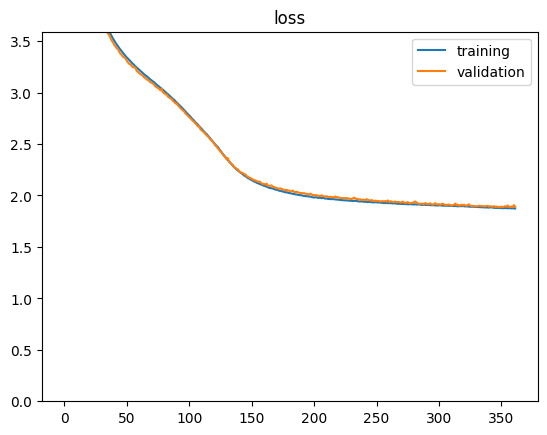

In [21]:
column = 'loss'

plt.plot(history.epoch, history.history[column], label = 'training')
plt.plot(history.epoch, history.history['val_' + column], label = 'validation')
plt.ylim(0, np.nanpercentile(history.history[column], 90))
plt.title(column)
plt.legend()
plt.show()

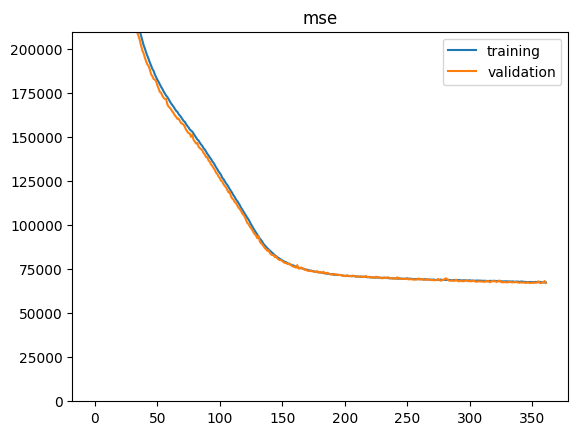

In [22]:
column = 'mse'

plt.plot(history.epoch, history.history[column], label = 'training')
plt.plot(history.epoch, history.history['val_' + column], label = 'validation')
plt.ylim(0, np.nanpercentile(history.history[column], 90))
plt.title(column)
plt.legend()
plt.show()

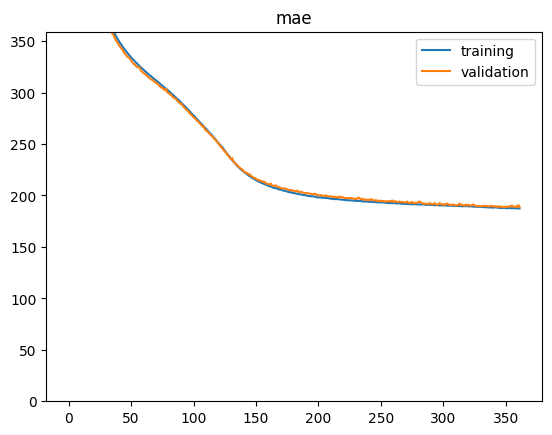

In [23]:
column = 'mae'

plt.plot(history.epoch, history.history[column], label = 'training')
plt.plot(history.epoch, history.history['val_' + column], label = 'validation')
plt.ylim(0, np.nanpercentile(history.history[column], 90))
plt.title(column)
plt.legend()
plt.show()

## Save model

In [24]:
model.save(PATH_MODEL)

## Save scaler

In [25]:
pickle.dump(scaler, open(PATH_SCALER, 'wb'))

## Save data

In [26]:
df_train = y_train.copy()
df_train[X_train.columns] = X_train[X_train.columns]
df_vali = y_vali.copy()
df_vali[X_vali.columns] = X_vali[X_vali.columns]

pickle.dump(df_train, open(PATH_DF_02, 'wb'))
pickle.dump(df_vali, open(PATH_DF_03, 'wb'))
pickle.dump(df_test, open(PATH_DF_04, 'wb'))

## Load model

In [27]:
model = load_model(PATH_MODEL)

## Evaluation

In [28]:
y_train_pred = model.predict(X_train_scaled)
y_vali_pred = model.predict(X_vali_scaled)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)

rmse_vali = np.sqrt(mean_squared_error(y_vali, y_vali_pred))
mae_vali = mean_absolute_error(y_vali, y_vali_pred)
mape_vali = mean_absolute_percentage_error(y_vali, y_vali_pred)

print('trianing; RMSE: {:.1f} MW, MAE: {:.1f} MW, MAPE: {:.1%}'.format(rmse_train, mae_train, mape_train))
print('validation; RMSE: {:.1f} MW, MAE: {:.1f} MW, MAPE: {:.1%}'.format(rmse_vali, mae_vali, mape_vali))

trianing; RMSE: 259.6 MW, MAE: 187.1 MW, MAPE: 3.7%
validation; RMSE: 259.2 MW, MAE: 188.6 MW, MAPE: 3.7%


## Shape of load

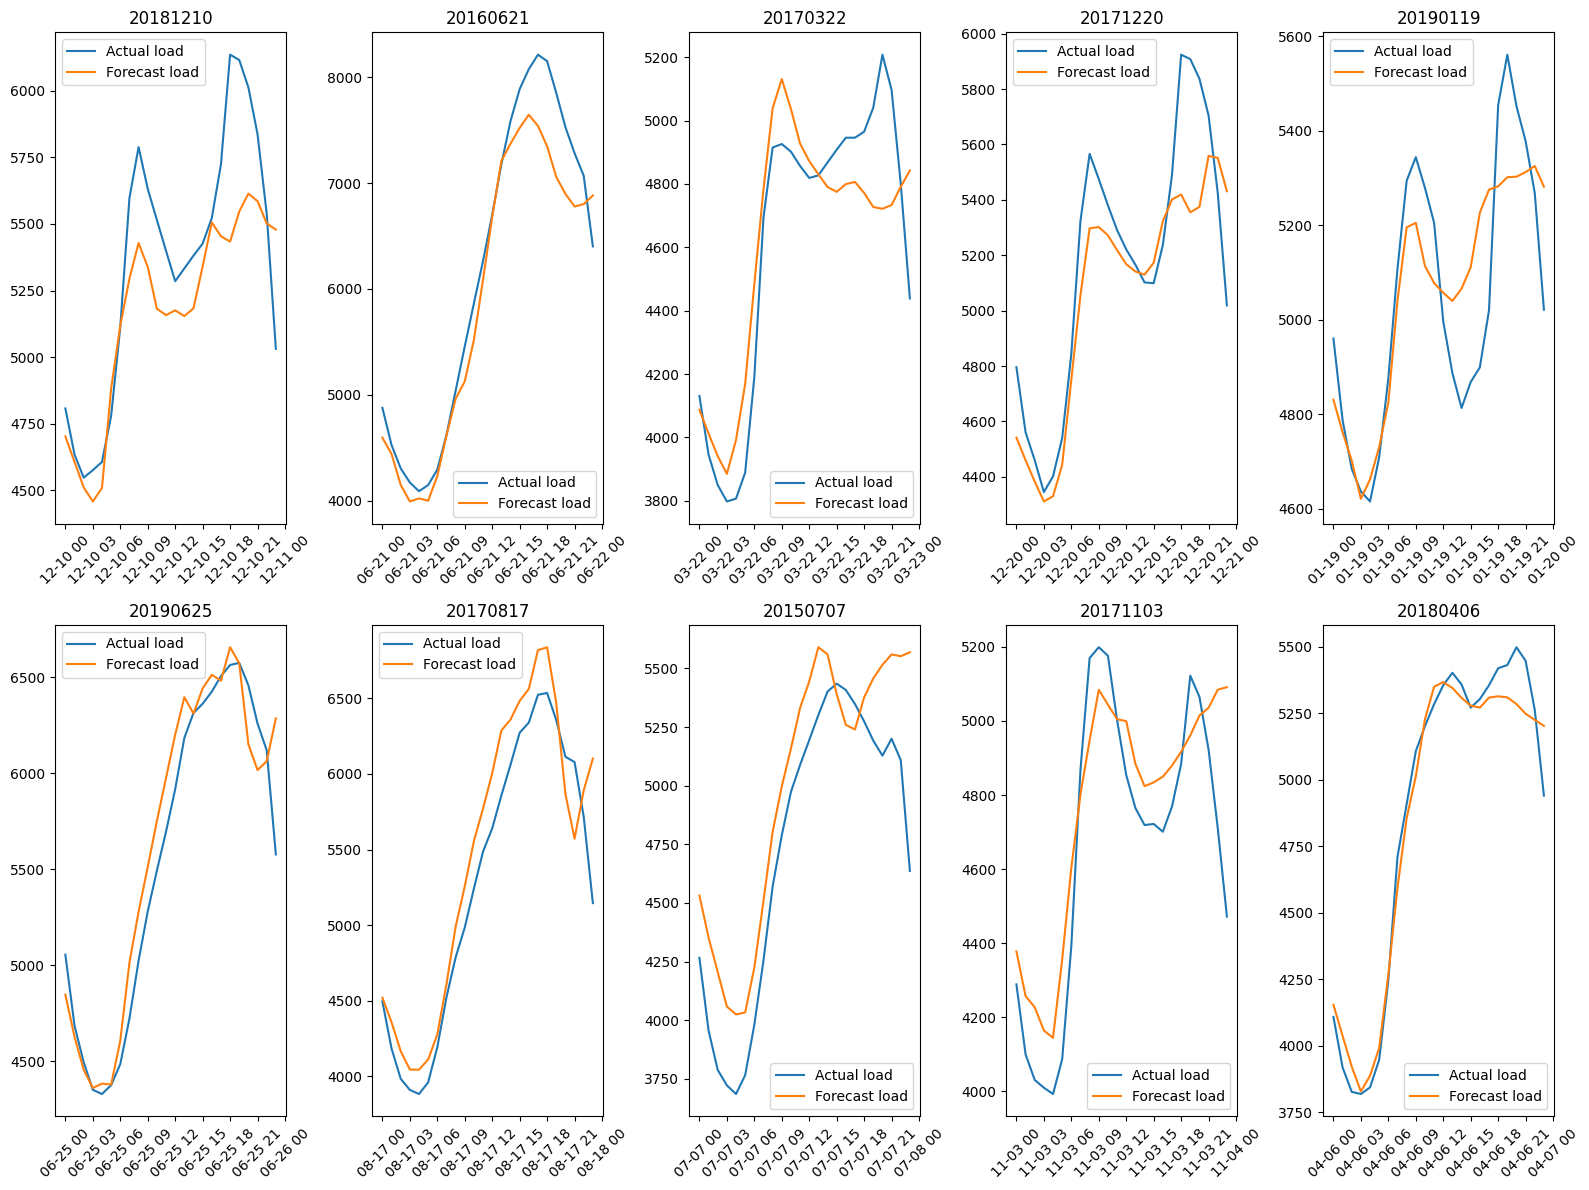

In [29]:
df_train['forecast_load'] = y_train_pred
df_train['split'] = 'train'
df_vali['forecast_load'] = y_vali_pred
df_vali['split'] = 'vali'
df_pred = df_train.append(df_vali)
df_pred = df_pred.sort_index()

dates = np.random.choice(df_pred.index, 10)

plt.figure(figsize = (8*2, 6*2))
for i, date in enumerate(dates):
    date = pd.to_datetime(date)
    plt.subplot(2, 5, i+1)
    plt.plot(df_pred[date.strftime('%Y%m%d')]['load'], label = 'Actual load')
    plt.plot(df_pred[date.strftime('%Y%m%d')]['forecast_load'], label = 'Forecast load')
    plt.legend()
    plt.xticks(rotation = 45)
    plt.title(date.strftime('%Y%m%d'))
    
plt.tight_layout()
plt.show()